# Project for Lecture 6: Yield Curve Spread Trades
MFGMTMFE 400 Investments - Cohort 1  
Group 9: Mingqi Sui, Diana Zhang, Tong Liu, Valentina Cortés, Edoardo Pettinato

## Part(a)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the uploaded Federal bond data file
file_path_2 = r'C:\Users\76721\Desktop\UCLA\Fall-2024\Investments\Lecture 7\sp500_2022.csv'
sp500 = pd.read_csv(file_path_2)
sp500['caldt'] = pd.to_datetime(sp500['caldt'], format='%Y%m%d')

# Filter the data between 1/3/1972 and 12/31/2021
start_date = '1972-01-03'
end_date = '2021-12-31'
filtered_sp500 = sp500[(sp500['caldt'] >= start_date) & (sp500['caldt'] <= end_date)]


data = filtered_sp500.copy()
# Calculate daily return 



def future_cumulative_return(data, window):
    result = []
    for i in range(len(data)):
        if i + window <= len(data):  # Check if there are enough rows
            window_data = data[i:i+window]
            cumulative_product = (1 + window_data).prod() - 1
            result.append(cumulative_product)
        else:
            result.append(None)  # Assign None (interpreted as NaN in pandas)
    return result



# Calculate daily, monthly, yearly and 5-year return
# Assume 21/252 trading days for a month and a year
trading_days = [21,252,252*5]
data['arithmetic_return_1m'] = future_cumulative_return(data['vwretd'].values,trading_days[0])
data['arithmetic_return_1y'] = future_cumulative_return(data['vwretd'].values,trading_days[1])
data['arithmetic_return_5y'] = future_cumulative_return(data['vwretd'].values,trading_days[2])
data.set_index('caldt', inplace = True)
data.head()



,vwretd,arithmetic_return_1m,arithmetic_return_1y,arithmetic_return_5y
caldt,,,,
1972-01-03,-0.004136,0.019074,0.202812,0.245686
1972-01-04,0.004200,0.024235,0.212658,0.257630
1972-01-05,0.009352,0.026571,0.205196,0.259272
1972-01-06,0.004271,0.017260,0.198670,0.242202
1972-01-07,-0.000263,0.015939,0.193324,0.222299


In [4]:
# Calculate the arithmetic average for each return type
avg_arithmetic_return_1d = data['vwretd'].mean()
avg_arithmetic_return_1m = data['arithmetic_return_1m'].mean()
avg_arithmetic_return_1y = data['arithmetic_return_1y'].mean()
avg_arithmetic_return_5y = data['arithmetic_return_5y'].mean()

# Define function to calculate the nth root of cumulative return using logarithms
def geometric_avg_return(data):
    non_na_data = data.dropna()  # Remove NA values
    n = len(non_na_data)
    log_sum = np.log1p(non_na_data).sum()  # Sum of logarithms
    nth_root = np.expm1(log_sum / n)  # e^(sum of logs / n) - 1
    return nth_root

# Calculate geometric average return 
avg_geometric_return_1d = geometric_avg_return(data['vwretd'])
avg_geometric_return_1m = geometric_avg_return(data['arithmetic_return_1m'])
avg_geometric_return_1y = geometric_avg_return(data['arithmetic_return_1y'])
avg_geometric_return_5y = geometric_avg_return(data['arithmetic_return_5y'])


# Define a dictionary to hold the calculated values


results = {
    "Arithmetic Average": [
        avg_arithmetic_return_1d,
        avg_arithmetic_return_1m,
        avg_arithmetic_return_1y,
        avg_arithmetic_return_5y,
    ],
    "Geometric Average": [
        avg_geometric_return_1d,
        avg_geometric_return_1m,
        avg_geometric_return_1y,
        avg_geometric_return_5y,
    ],
    "Annualized Arithmetic Average": [
        avg_arithmetic_return_1d * 252,  # Daily to Annual
        avg_arithmetic_return_1m * 12,   # Monthly to Annual
        avg_arithmetic_return_1y,        # Yearly is already annualized
        avg_arithmetic_return_5y / 5,    # 5-Year to Annual
    ],
    "Annualized Geometric Average": [
        (1 + avg_geometric_return_1d) ** 365 - 1,  # Daily to Annual
        (1 + avg_geometric_return_1m) ** 12 - 1,   # Monthly to Annual
        avg_geometric_return_1y,                   # Yearly is already annualized
        (1 + avg_geometric_return_5y) ** (1 / 5) - 1,  # 5-Year to Annual
    ],
}

# Create a DataFrame with rows labeled as Daily, Monthly, Yearly, and 5-Year
df_results = pd.DataFrame(results, index=["Daily", "Monthly", "Yearly", "5-Year"])

df_results


,Arithmetic Average,Geometric Average,Annualized Arithmetic Average,Annualized Geometric Average
Daily,0.000478,0.000419,0.120564,0.165363
Monthly,0.009871,0.008809,0.118451,0.110977
Yearly,0.123179,0.109345,0.123179,0.109345
5-Year,0.797373,0.698527,0.159475,0.111769


## Part(b)

In [6]:
# Load the uploaded Federal bond data file
file_path = r'C:\Users\76721\Desktop\UCLA\Fall-2024\Investments\Lecture 4\feds200628.csv'
bonds = pd.read_csv(file_path, skiprows=9)


# Adjusting to use the 'Date' column and re-running the previous setup steps
bonds.rename(columns={'Date': 'Dates'}, inplace=True)
bonds['Dates'] = pd.to_datetime(bonds['Dates'], errors='coerce')

# Select only the columns related to zero-coupon bonds and filter complete rows (no missing data)
zero_bonds = bonds[['Dates', 'SVENY01', 'SVENY05', 'BETA0', 'BETA1', 'BETA2', 'BETA3', 'TAU1', 'TAU2']].dropna()

# Convert the dataframe to a time series format, restricting dates between 1983-12-30 and 2017-06-30
zero_bonds.set_index('Dates', inplace=True)
spot_rates = zero_bonds['1972-01-03':'2021-12-31']

# Display initial data to verify structure
spot_rates.head()

,SVENY01,SVENY05,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
Dates,,,,,,,,
1972-01-03,4.3726,5.5782,6.500485,-2.792355,0.001590,0.0,1.753532,-999.99
1972-01-04,4.3461,5.5708,6.539252,-2.854089,-0.000074,0.0,1.811106,-999.99
1972-01-05,4.3115,5.5698,6.589933,-2.947018,-0.003512,0.0,1.854106,-999.99
1972-01-06,4.2452,5.5558,6.564901,-3.039058,0.001389,0.0,1.764591,-999.99
1972-01-07,4.1833,5.5350,6.547381,-3.119628,0.002522,0.0,1.717120,-999.99


In [7]:
# Rename columns to match the required names for 1-year and 5-year bond yields
spot_rates.rename(columns={"SVENY01": "yield.1y", "SVENY05": "yield.5y"}, inplace=True)

# Define function to estimate the yield of bonds using Nelson-Siegel parameters
def estimated_yield(params, t):
    t1 = t / params['TAU1']
    t2 = t / params['TAU2']
    yield_estimate = (
        params['BETA0'] + 
        params['BETA1'] * (1 - np.exp(-t1)) / t1 + 
        params['BETA2'] * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + 
        params['BETA3'] * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))
    )
    return yield_estimate
# Apply the estimated yield function row-wise using TAU and BETA parameters
ttm = [1/252,1/12,1]
treasury_yield = spot_rates[["yield.1y","yield.5y"]].copy()

treasury_yield['yield.1d'] = spot_rates.apply(lambda row: estimated_yield(row, ttm[0]), axis=1)
treasury_yield['yield.1m'] = spot_rates.apply(lambda row: estimated_yield(row, ttm[1]), axis=1)
#treasury_yield['yield.1y'] = spot_rates.apply(lambda row: estimated_yield(row, ttm[2]), axis=1) check for output value of 1 year yield curve

# Display initial rows of the portfolio to verify the calculated off-the-run yields
treasury_yield.head()

C:\Users\76721\AppData\Local\Temp\ipykernel_3400\2659350512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spot_rates.rename(columns={"SVENY01": "yield.1y", "SVENY05": "yield.5y"}, inplace=True)


,yield.1y,yield.5y,yield.1d,yield.1m
Dates,,,,
1972-01-03,4.3726,5.5782,3.711289,3.773479
1972-01-04,4.3461,5.5708,3.688288,3.749828
1972-01-05,4.3115,5.5698,3.646062,3.708084
1972-01-06,4.2452,5.5558,3.529259,3.596519
1972-01-07,4.1833,5.5350,3.431358,3.502301


In [8]:
# convert continous compounding to discret compounding
treasury_yield.iloc[:, :] = np.exp(treasury_yield.iloc[:, :]/100) - 1

# Displaying the transformed dataset
treasury_yield.head()

,yield.1y,yield.5y,yield.1d,yield.1m
Dates,,,,
1972-01-03,0.044696,0.057367,0.037810,0.038456
1972-01-04,0.044419,0.057289,0.037571,0.038210
1972-01-05,0.044058,0.057278,0.037133,0.037777
1972-01-06,0.043366,0.057130,0.035923,0.036620
1972-01-07,0.042720,0.056910,0.034909,0.035644


In [9]:
# convert daily/monthly/5yr index return to annualized return

index_data = pd.DataFrame()
index_data['return.1d'] = (1+data['vwretd']) ** 252 - 1   # 252 trading days in a year
index_data['return.1m'] = (1+data['arithmetic_return_1m']) ** 12 - 1
index_data['return.1y'] = data['arithmetic_return_1y']
index_data['return.5y'] = (1+data['arithmetic_return_5y']) ** (1/5)
index_data.head()

,return.1d,return.1m,return.1y,return.5y
caldt,,,,
1972-01-03,-0.648109,0.254494,0.202812,1.044917
1972-01-04,1.875376,0.332886,0.212658,1.046913
1972-01-05,9.441124,0.369838,0.205196,1.047186
1972-01-06,1.927065,0.227959,0.198670,1.044332
1972-01-07,-0.064136,0.208962,0.193324,1.040963


            return.1d  yield.1d  Difference
1972-01-03  -0.648109  0.037810   -0.685919
1972-01-04   1.875376  0.037571    1.837805
1972-01-05   9.441124  0.037133    9.403991
1972-01-06   1.927065  0.035923    1.891142
1972-01-07  -0.064136  0.034909   -0.099045
...               ...       ...         ...
2021-12-27  29.425826 -0.001487   29.427313
2021-12-28  -0.218528 -0.001270   -0.217258
2021-12-29   0.378637 -0.001294    0.379931
2021-12-30  -0.525148 -0.001002   -0.524145
2021-12-31  -0.481629 -0.000609   -0.481020

[12460 rows x 3 columns]


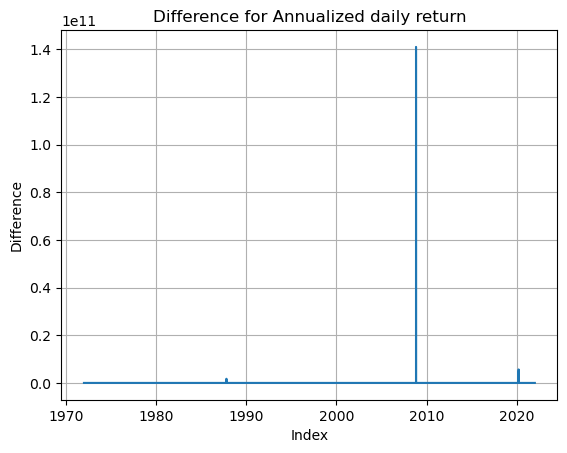

In [10]:
# Calculate the difference between Annualized index daily_return vs Annualized one-day ZBC yield rate
type1 = 'return.1d'
type2 = 'yield.1d'
df1_cleaned = index_data.dropna(subset = [type1])
common_index = treasury_yield.index.intersection(df1_cleaned.index)
df1_common = index_data.loc[common_index][type1]
df2_common = treasury_yield.loc[common_index][type2]
difference = df1_common - df2_common
daily_difference = pd.DataFrame({
    type1:df1_common,
    type2:df2_common,
    'Difference':difference
}, index = common_index)

print(daily_difference)

# Plot the trend of difference
plt.plot(common_index, difference)
plt.title('Difference for Annualized daily return')
plt.xlabel('Index')
plt.ylabel('Difference')
plt.grid()
plt.show()
plt.show()

            return.1m  yield.1m  Difference
1972-01-03   0.254494  0.038456    0.216039
1972-01-04   0.332886  0.038210    0.294676
1972-01-05   0.369838  0.037777    0.332061
1972-01-06   0.227959  0.036620    0.191340
1972-01-07   0.208962  0.035644    0.173318
...               ...       ...         ...
2021-11-26   0.258077  0.002740    0.255338
2021-11-29   0.637967  0.002840    0.635127
2021-11-30   0.419769  0.002549    0.417220
2021-12-01   0.719644 -0.001370    0.721014
2021-12-02   0.929299  0.001269    0.928031

[12440 rows x 3 columns]


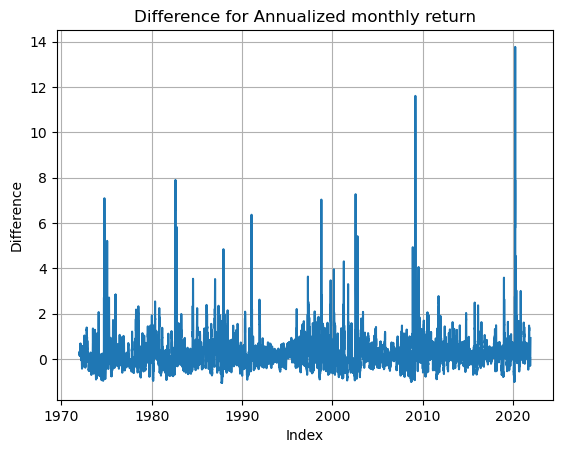

In [11]:
# Calculate the difference between Annualized index monlyly_return vs Annualized one-month ZBC yield rate
type1 = 'return.1m'
type2 = 'yield.1m'
df1_cleaned = index_data.dropna(subset = [type1])
common_index = treasury_yield.index.intersection(df1_cleaned.index)
df1_common = index_data.loc[common_index][type1]
df2_common = treasury_yield.loc[common_index][type2]
difference = df1_common - df2_common
monthly_difference = pd.DataFrame({
    type1:df1_common,
    type2:df2_common,
    'Difference':difference
}, index = common_index)

print(monthly_difference)

# Plot the trend of difference
plt.plot(common_index, difference)
plt.title('Difference for Annualized monthly return')
plt.xlabel('Index')
plt.ylabel('Difference')
plt.grid()
plt.show()
plt.show()

            return.1y  yield.1y  Difference
1972-01-03   0.202812  0.044696    0.158116
1972-01-04   0.212658  0.044419    0.168239
1972-01-05   0.205196  0.044058    0.161138
1972-01-06   0.198670  0.043366    0.155304
1972-01-07   0.193324  0.042720    0.150604
...               ...       ...         ...
2020-12-28   0.308971  0.001204    0.307767
2020-12-29   0.296131  0.001187    0.294944
2020-12-30   0.300690  0.001243    0.299448
2020-12-31   0.294930  0.001173    0.293758
2021-01-04   0.283374  0.001082    0.282293

[12211 rows x 3 columns]


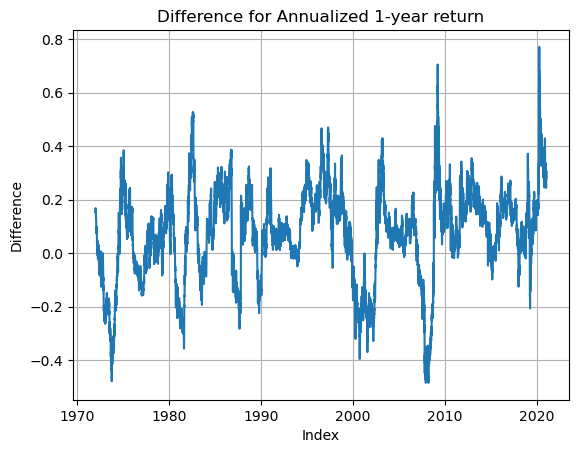

In [12]:
# Calculate the difference between Annualized index year_return vs Annualized one-year ZBC yield rate
type1 = 'return.1y'
type2 = 'yield.1y'
df1_cleaned = index_data.dropna(subset = [type1])
common_index = treasury_yield.index.intersection(df1_cleaned.index)
df1_common = index_data.loc[common_index][type1]
df2_common = treasury_yield.loc[common_index][type2]
difference = df1_common - df2_common
yearly_difference = pd.DataFrame({
    type1:df1_common,
    type2:df2_common,
    'Difference':difference
}, index = common_index)

print(yearly_difference)

# Plot the trend of difference
plt.plot(common_index, difference)
plt.title('Difference for Annualized 1-year return')
plt.xlabel('Index')
plt.ylabel('Difference')
plt.grid()
plt.show()
plt.show()

            return.5y  yield.5y  Difference
1972-01-03   1.044917  0.057367    0.987550
1972-01-04   1.046913  0.057289    0.989624
1972-01-05   1.047186  0.057278    0.989908
1972-01-06   1.044332  0.057130    0.987201
1972-01-07   1.040963  0.056910    0.984053
...               ...       ...         ...
2016-12-23   1.184024  0.021045    1.162979
2016-12-27   1.183472  0.021293    1.162180
2016-12-28   1.183231  0.020767    1.162464
2016-12-29   1.184467  0.020262    1.164206
2016-12-30   1.183908  0.019983    1.163925

[11210 rows x 3 columns]


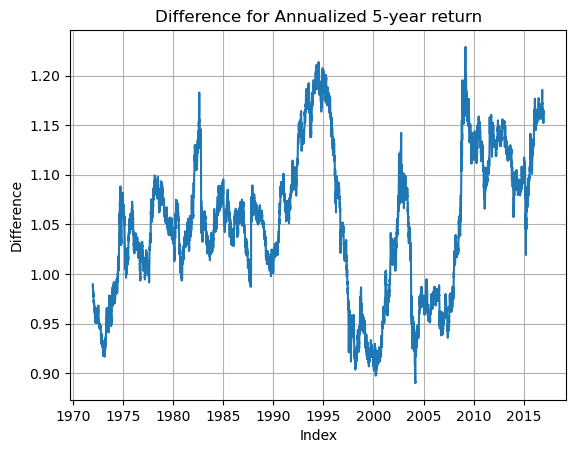

In [13]:
# Calculate the difference between Annualized index 5yr_return vs Annualized 5 year ZBC yield rate
type1 = 'return.5y'
type2 = 'yield.5y'
df1_cleaned = index_data.dropna(subset = [type1])
common_index = treasury_yield.index.intersection(df1_cleaned.index)
df1_common = index_data.loc[common_index][type1]
df2_common = treasury_yield.loc[common_index][type2]
difference = df1_common - df2_common
Five_yrs_difference = pd.DataFrame({
    type1:df1_common,
    type2:df2_common,
    'Difference':difference
}, index = common_index)

print(Five_yrs_difference)

# Plot the trend of difference
plt.plot(common_index, difference)
plt.title('Difference for Annualized 5-year return')
plt.xlabel('Index')
plt.ylabel('Difference')
plt.grid()
plt.show()
plt.show()

In [14]:
# Calculate daily, monthly, yearly and 5-year return

# Calculate the arithmetic average for each return type
avg_arithmetic_return_1d = round(daily_difference['Difference'].mean(),6)
avg_arithmetic_return_1m = round(monthly_difference['Difference'].mean(),6)
avg_arithmetic_return_1y = round(yearly_difference['Difference'].mean(),6)
avg_arithmetic_return_5y = round(Five_yrs_difference['Difference'].mean(),6)

# Calculate geometric average return 
avg_geometric_return_1d = geometric_avg_return(daily_difference['Difference'])
avg_geometric_return_1m = geometric_avg_return(monthly_difference['Difference'])
avg_geometric_return_1y = geometric_avg_return(yearly_difference['Difference'])
avg_geometric_return_5y = geometric_avg_return(Five_yrs_difference['Difference'])


# Define a dictionary to hold the calculated values


results_exR = {
  
    "Arithmetic Average of Annualized  difference": [
        avg_arithmetic_return_1d ,  # Daily to Annual
        avg_arithmetic_return_1m ,   # Monthly to Annual
        avg_arithmetic_return_1y,        # Yearly is already annualized
        avg_arithmetic_return_5y ,    # 5-Year to Annual
    ],
    "Geometric Average of Annualized  difference": [
        avg_geometric_return_1d,  # Daily to Annual
        avg_geometric_return_1m,   # Monthly to Annual
        avg_geometric_return_1y,                   # Yearly is already annualized
        avg_geometric_return_5y,  # 5-Year to Annual
    ],
}

# Create a DataFrame with rows labeled as Daily, Monthly, Yearly, and 5-Year
df_results = pd.DataFrame(results_exR, index=["Daily", "Monthly", "Yearly", "5-Year"])

# Set display format for pandas
pd.options.display.float_format = '{:.5f}'.format
df_results

C:\Users\76721\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Arithmetic Average of Annualized difference,Geometric Average of Annualized difference
Daily,12315488.47422,0.46583
Monthly,0.22608,0.05552
Yearly,0.07103,0.05601
5-Year,1.05090,1.04959


## Part(c)

In [16]:
# Asset allocation between 1-day index and 1-day zbc

# Parameters
A = 4 # Coefficient of risk aversion

# Calculate statistics
mu_r = daily_difference['return.1d'].mean()
r_f = daily_difference['yield.1d'].mean()

sigma_squared = daily_difference['return.1d'].var()

# Calculate the weight for index
w_index = (mu_r - r_f)/(A *sigma_squared)

# Weight for bonds
w_bonds = 1 - w_index

# Display allocation
print(f"Allocation to Index:{w_index * 100:.2f}%")
print(f"Allocation to Bonds:{w_bonds * 100:.2f}%")


Allocation to Index:0.00%
Allocation to Bonds:100.00%


In [17]:
# Asset allocation between 1-month index and 1-month zbc

# Parameters
A = 4 # Coefficient of risk aversion

# Calculate statistics
mu_r = monthly_difference['return.1m'].mean()
r_f = monthly_difference['yield.1m'].mean()

sigma_squared = monthly_difference['return.1m'].var()

# Calculate the weight for index
w_index = (mu_r - r_f)/(A *sigma_squared)

# Weight for bonds
w_bonds = 1 - w_index

# Display allocation
print(f"Allocation to Index:{w_index * 100:.2f}%")
print(f"Allocation to Bonds:{w_bonds * 100:.2f}%")

Allocation to Index:10.55%
Allocation to Bonds:89.45%


In [18]:
# Asset allocation between 1-year index and 1-year zbc

# Parameters
A = 4 # Coefficient of risk aversion

# Calculate statistics
mu_r = yearly_difference['return.1y'].mean()
r_f = yearly_difference['yield.1y'].mean()

sigma_squared = yearly_difference['return.1y'].var()

# Calculate the weight for index
w_index = (mu_r - r_f)/(A *sigma_squared)

# Weight for bonds
w_bonds = 1 - w_index

# Display allocation
print(f"Allocation to Index:{w_index * 100:.2f}%")
print(f"Allocation to Bonds:{w_bonds * 100:.2f}%")

Allocation to Index:61.64%
Allocation to Bonds:38.36%


In [19]:
# Asset allocation between 5-year index and 5-year zbc

# Parameters
A = 4 # Coefficient of risk aversion

# Calculate statistics
mu_r = Five_yrs_difference['return.5y'].mean()
r_f = Five_yrs_difference['yield.5y'].mean()

sigma_squared = Five_yrs_difference['return.5y'].var()

# Calculate the weight for index
w_index = (mu_r - r_f)/(A *sigma_squared)

# Weight for bonds
w_bonds = 1 - w_index

# Display allocation
print(f"Allocation to Index:{w_index * 100:.2f}%")
print(f"Allocation to Bonds:{w_bonds * 100:.2f}%")

Allocation to Index:4579.24%
Allocation to Bonds:-4479.24%
